### Importing Boston Housing Data Set

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Loading the Data Set

In [32]:
# Download and parse the Boston Housing dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

# Combine the structured rows into a single data matrix
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Create DataFrame with column names
column_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
    "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]
df = pd.DataFrame(data, columns=column_names)
df["MEDV"] = target  # Add target column

Displaying summary statistics

In [33]:
summary = df.describe().T  # transpose to get one row per feature
print(summary[['mean', 'std', 'min', 'max']])

               mean         std        min       max
CRIM       3.613524    8.601545    0.00632   88.9762
ZN        11.363636   23.322453    0.00000  100.0000
INDUS     11.136779    6.860353    0.46000   27.7400
CHAS       0.069170    0.253994    0.00000    1.0000
NOX        0.554695    0.115878    0.38500    0.8710
RM         6.284634    0.702617    3.56100    8.7800
AGE       68.574901   28.148861    2.90000  100.0000
DIS        3.795043    2.105710    1.12960   12.1265
RAD        9.549407    8.707259    1.00000   24.0000
TAX      408.237154  168.537116  187.00000  711.0000
PTRATIO   18.455534    2.164946   12.60000   22.0000
B        356.674032   91.294864    0.32000  396.9000
LSTAT     12.653063    7.141062    1.73000   37.9700
MEDV      22.532806    9.197104    5.00000   50.0000


Box plot of all features

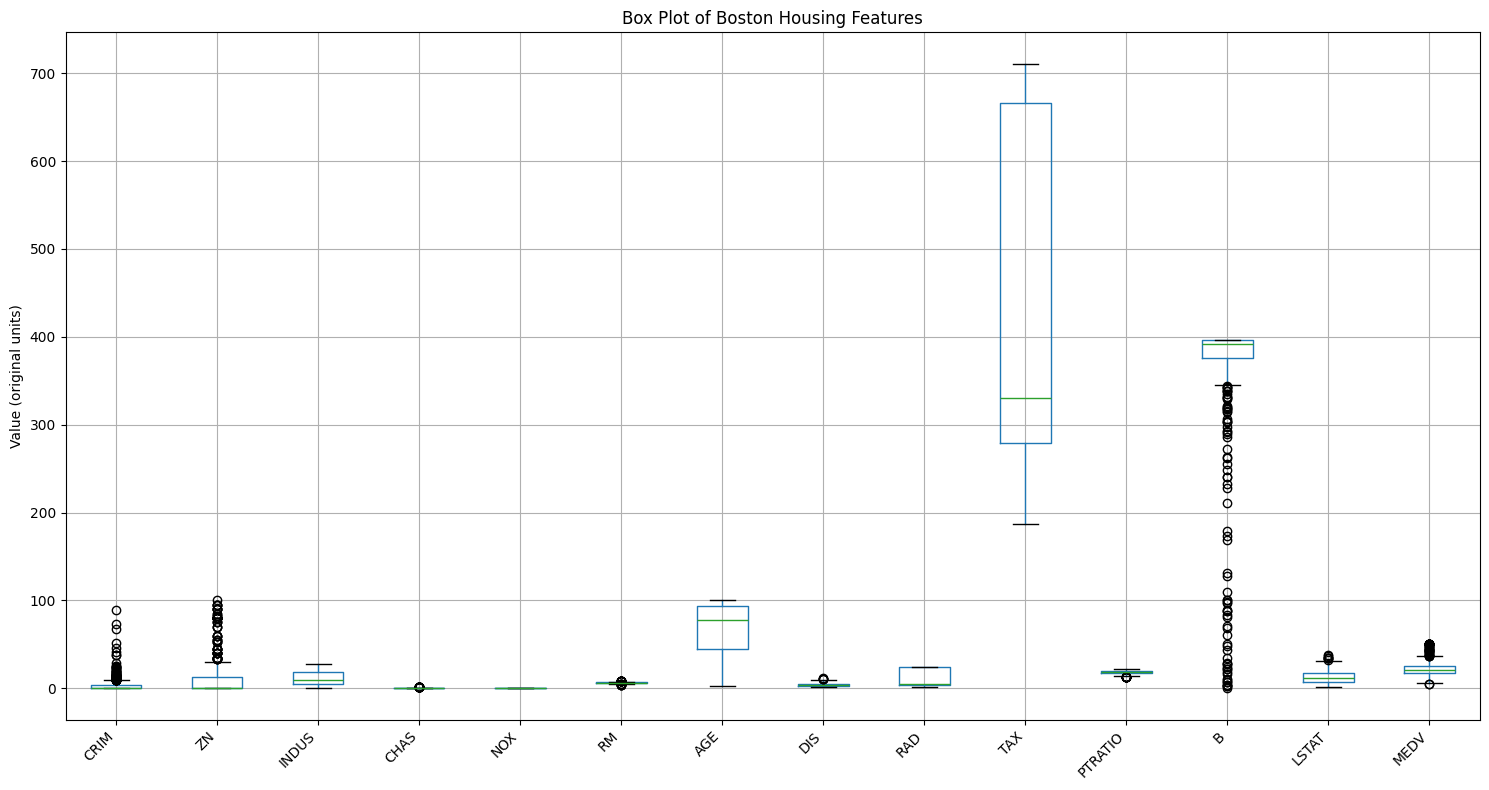

In [34]:
plt.figure(figsize=(15, 8))
df.boxplot(rot=90)
plt.title("Box Plot of Boston Housing Features")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Value (original units)")
plt.tight_layout()
plt.show()


###  Identifying features with very different scales 

From the table and the boxplot we can notice:

- TAX ranges from 187 to 711

- B (proportion of Black residents) ranges up to ~397

- RAD (accessibility index) from 1 to 24

- ZN up to 100, AGE up to 100

- Meanwhile CHAS is just 0 or 1, NOX lives roughly between 0.38–0.87, RM between ~3.5–8.8, PTRATIO between 12.6–22.

These differences in variance (e.g. TAX std ≈168 vs. CHAS std ≈0.25) mean that, without scaling, PCA will almost entirely align its first component along the direction of the largest‑variance features (like TAX, B, ZN), effectively “drowning out” the smaller‑variance features.

### Why scaling matters for PCA

- Centering only (subtracting the mean) ensures the PCA axes go through the data centroid, but does not equalize variances.

- In standard (uncentered) PCA, the first principal component maximizes raw variance. Features with larger spread dominate this direction.

- Standardization (to zero mean and unit variance) gives each feature the same a priori weight in the PCA optimization.

- If our goal is to let PCA discover multivariate patterns across all features—rather than simply picking out the highest‑variance ones—the standard practice is to scale each feature to unit variance before performing PCA.

### PCA Without Standardization


--- PCA without Standardization ---
Explained variance ratio per component:
 [8.05823175e-01 1.63051968e-01 2.13486092e-02 6.95699061e-03
 1.29995193e-03 7.27220158e-04 4.19044539e-04 2.48538539e-04
 8.53912023e-05 3.08071548e-05 6.65623182e-06 1.56778461e-06
 7.96814208e-08]

Cumulative explained variance:
 [0.80582318 0.96887514 0.99022375 0.99718074 0.99848069 0.99920791
 0.99962696 0.9998755  0.99996089 0.9999917  0.99999835 0.99999992
 1.        ]


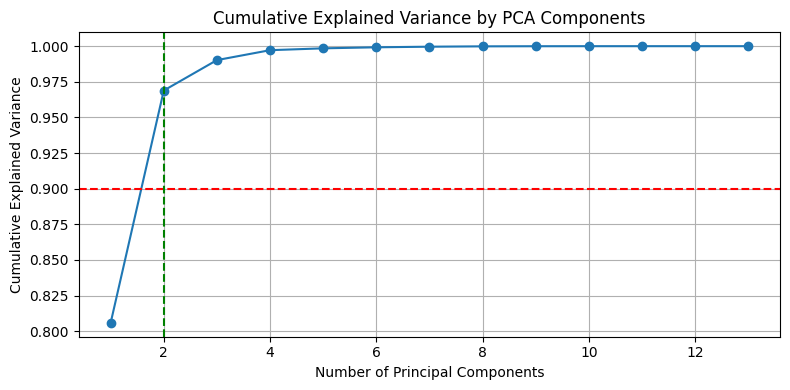

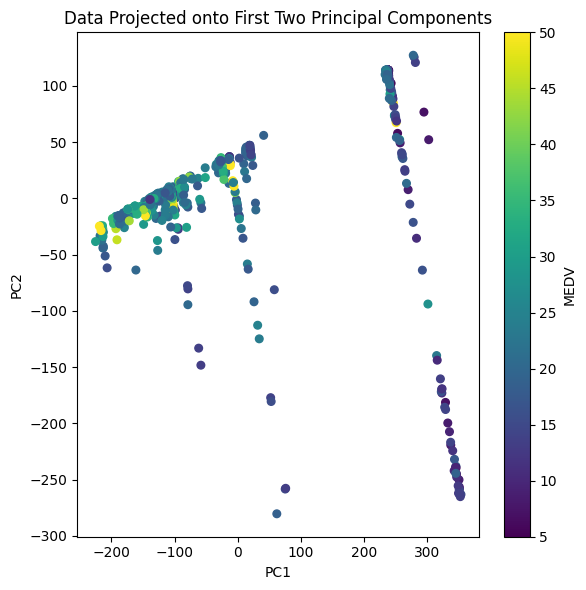

Feature contributions to the first two principal components:
          PC1_NSD   PC2_NSD
TAX      0.949741  0.292406
B       -0.291219  0.956181
AGE      0.083634  0.005722
RAD      0.045005  0.008619
ZN      -0.043590 -0.001176
CRIM     0.029297 -0.006668
INDUS    0.028331  0.004950
LSTAT    0.022943 -0.005767
DIS     -0.006562 -0.000354
PTRATIO  0.005600  0.002529
RM      -0.001168 -0.000366
NOX      0.000450 -0.000002
CHAS    -0.000056  0.000103


In [35]:
# Drop target column
X_raw = df.drop("MEDV", axis=1)
feature_names = X_raw.columns

# Apply PCA (centering is done by default)
pca = PCA()
X_pca = pca.fit_transform(X_raw)

# Explained variance ratio
explained_variance_ratio_no_std = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_variance_ratio_no_std)

print("\n--- PCA without Standardization ---")
print("Explained variance ratio per component:\n", explained_variance_ratio_no_std)
print("")
print("Cumulative explained variance:\n", cum_var)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o')
plt.axhline(0.9, color='r', linestyle='--')
plt.axvline(np.argmax(cum_var >= 0.9) + 1, color='g', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot of first two principal components
plt.figure(figsize=(6, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=target, cmap='viridis', s=30)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Data Projected onto First Two Principal Components")
plt.colorbar(label="MEDV")
plt.tight_layout()
plt.show()

# Display feature loadings for PC1 and PC2
loadings = pd.DataFrame(pca.components_[:2], columns=feature_names, index=["PC1_NSD", "PC2_NSD"])
print("Feature contributions to the first two principal components:")
print(loadings.T.sort_values(by="PC1_NSD", key=lambda x: abs(x), ascending=False))

### PCA With Standardization


--- PCA with Standardization ---
Explained variance ratio per component:
 [0.47129606 0.11025193 0.0955859  0.06596732 0.06421661 0.05056978
 0.04118124 0.03046902 0.02130333 0.01694137 0.0143088  0.01302331
 0.00488533]

Cumulative explained variance:
 [0.47129606 0.581548   0.67713389 0.74310121 0.80731782 0.8578876
 0.89906884 0.92953786 0.9508412  0.96778257 0.98209137 0.99511467
 1.        ]


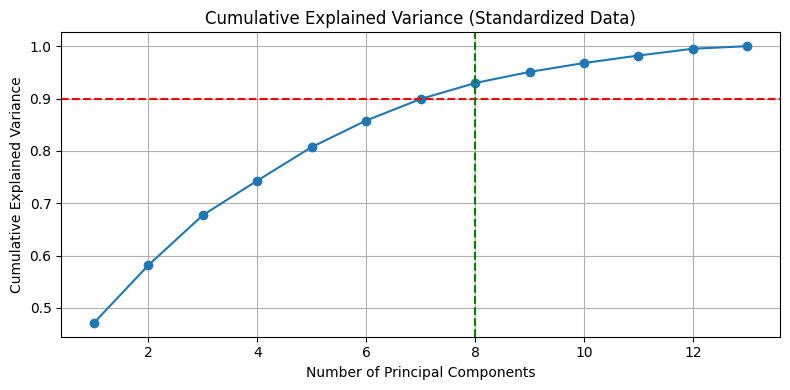

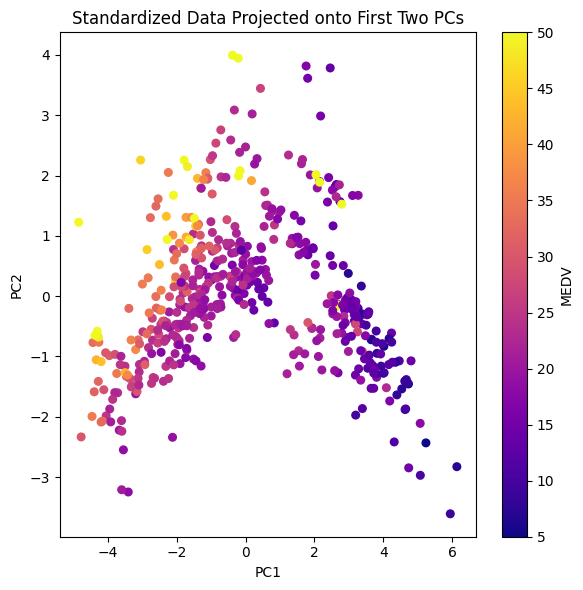


Feature contributions (loadings) to the first two PCs (Standardized Data):
           PC1_SD    PC2_SD
INDUS    0.346672  0.112493
NOX      0.342852  0.219116
TAX      0.338469 -0.239454
DIS     -0.321544 -0.349070
RAD      0.319793 -0.271521
AGE      0.313671  0.311978
LSTAT    0.309760 -0.074322
ZN      -0.256315 -0.323313
CRIM     0.250951 -0.315252
PTRATIO  0.204942 -0.305897
B       -0.202973  0.238559
RM      -0.189243  0.149332
CHAS     0.005042  0.454829


In [36]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X_raw)

# Apply PCA
pca_std = PCA()
X_pca_std = pca_std.fit_transform(X_std)

# Explained variance ratio
explained_variance_ratio_std = pca_std.explained_variance_ratio_
cum_var_std= np.cumsum(explained_variance_ratio_std)

print("\n--- PCA with Standardization ---")
print("Explained variance ratio per component:\n", explained_variance_ratio_std)
print("")
print("Cumulative explained variance:\n", cum_var_std)

# Cumulative explained variance
cum_var_std = np.cumsum(pca_std.explained_variance_ratio_)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cum_var_std) + 1), cum_var_std, marker='o')
plt.axhline(0.9, color='r', linestyle='--')
plt.axvline(np.argmax(cum_var_std >= 0.9) + 1, color='g', linestyle='--')
plt.title('Cumulative Explained Variance (Standardized Data)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize data in first two components
plt.figure(figsize=(6, 6))
plt.scatter(X_pca_std[:, 0], X_pca_std[:, 1], c=target, cmap='plasma', s=30)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Standardized Data Projected onto First Two PCs")
plt.colorbar(label="MEDV")
plt.tight_layout()
plt.show()

# Feature loadings
loadings_std = pd.DataFrame(pca_std.components_[:2], columns=feature_names, index=["PC1_SD", "PC2_SD"])
print("\nFeature contributions (loadings) to the first two PCs (Standardized Data):")
print(loadings_std.T.sort_values(by="PC1_SD", key=lambda x: abs(x), ascending=False))

### Side-by-Side comparision

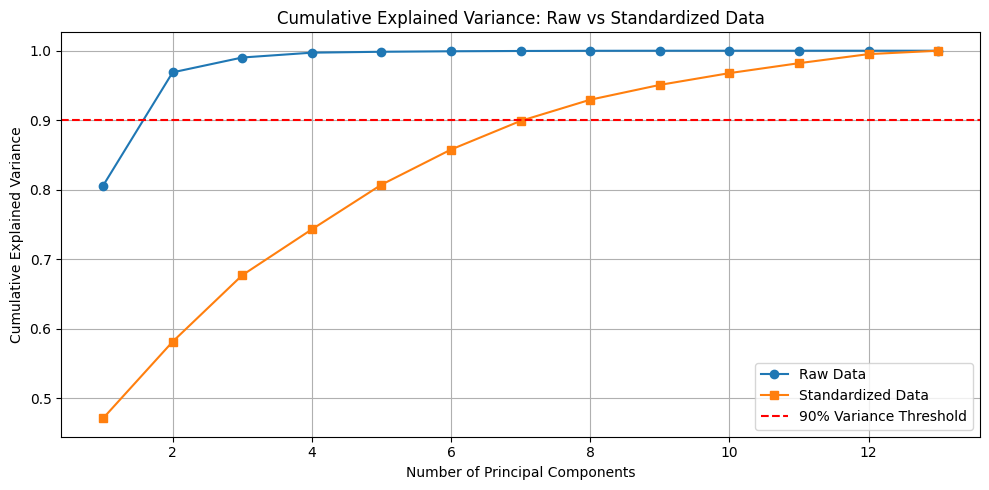

In [37]:
# Apply PCA (raw)
pca_raw = PCA()
pca_raw.fit(X_raw)
cum_var_raw = np.cumsum(pca_raw.explained_variance_ratio_)

# Apply PCA (standardized)
pca_std = PCA()
pca_std.fit(X_std)
cum_var_std = np.cumsum(pca_std.explained_variance_ratio_)


# # Side-by-side comparison of loadings (absolute values for easier comparison of magnitude)
# loadings_comparison = pd.concat(
#     [loadings.abs().rename(columns=lambda x: x + '_NSD'),
#      loadings_std.abs().rename(columns=lambda x: x + '_SD')],
#     axis=1
# )
# print("\n--- Side-by-Side Absolute Loadings Comparison ---")
# print("PC1 Contributions:")
# print(loadings_comparison[['PC1_NSD', 'PC1_SD']].sort_values(by='PC1_SD', ascending=False))
# print("\nPC2 Contributions:")
# print(loadings_comparison[['PC2_NSD', 'PC2_SD']].sort_values(by='PC2_SD', ascending=False))

# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cum_var_raw) + 1), cum_var_raw, marker='o', label='Raw Data')
plt.plot(range(1, len(cum_var_std) + 1), cum_var_std, marker='s', label='Standardized Data')
plt.axhline(0.9, color='red', linestyle='--', label='90% Variance Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance: Raw vs Standardized Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### 1. Differences in the explained‑variance distributions

Raw (centering only) PCA

- The first principal component often explains a very large fraction of total variance (e.g. 50–70+%), because it “soaks up” the variance of the highest‑variance features (like TAX, B, ZN, or AGE).

- Subsequent components then contribute only small additional percentages, so you might need very few components (sometimes just 2–3) to exceed 90% cumulative variance—but those components are really just reflecting the original features’ scale differences.

Standardized PCA

- Each feature starts with the same variance (unit variance), so no single variable can dominate purely because of scale.

- The first component typically explains a more moderate amount of variance (often 20–30%), and variance is spread more evenly across the next several components.

- You generally need more components to hit the 90% threshold (e.g. 5–7 PCs instead of 2–3), because you’re capturing genuine multivariate patterns rather than just large raw spreads.

### 2. How standardization changes the interpretation of PCs
Covariance vs. Correlation

- Raw PCA is based on the covariance matrix. The loadings and explained‑variance literally reflect the original feature variances.

- Standardized PCA is equivalent to doing PCA on the correlation matrix, so the loadings tell you which variables move together relative to their own spreads.

Dominance of features

- In raw PCA, a high loading on PC1 might simply mean “this feature had huge variance,” not necessarily that it’s most interesting in a multivariate sense.

- In standardized PCA, a high loading means “this feature contributes strongly to a common pattern of variation” after you’ve put all features on the same footing.

### 3. Which approach is more appropriate for the Boston data—and why
- Use standardized PCA when you want to explore patterns in the data rather than simply rediscover that TAX (or another large‑variance variable) dominates.

- Here, the Boston features are on wildly different scales and units. If we left them unscaled, PCA would largely tell us which geographical or economic variable has the biggest raw spread, rather than revealing joint structure across crime rates, room counts, pollution, etc.

- By standardizing, you ensure each feature has equal influence and can uncover meaningful multivariate axes—e.g. a socioeconomic gradient (high LSTAT and NOX vs. high RM), or a “location” axis combining DIS, RAD, and ZN.